<a href="https://colab.research.google.com/github/luigiselmi/dl_remote_sensing/blob/main/oxford_pets_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

In [54]:
import numpy as np
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import os
import tensorflow as tf
import keras
#from IPython.display import Image, display
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
print("NumPy version: %s"%np.__version__)
print('Tensorflow version: {:s}'.format(tf.__version__))
print('Keras version. {}'.format(keras.__version__))

NumPy version: 2.0.2
Tensorflow version: 2.18.0
Keras version. 3.8.0


## Download the data
The images are JPG file

In [4]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

#!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
#!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz

--2025-07-03 13:13:16--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-07-03 13:13:17--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M  23.6MB/s    in 33s     

2025-07-03 13:13:50 (23.2 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2025-07-03 13:13:50--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving w

In [5]:
!tar xvf images.tar.gz
!tar xvf annotations.tar.gz

Output streaming troncato alle ultime 5000 righe.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_

## Prepare paths of input images and target segmentation masks

In [6]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## What does one input image and corresponding segmentation mask look like?

In [47]:
img = Image.open(input_img_paths[9])
print(img.format)
img_array = np.asarray(img)
print(img_array.dtype)
img_array.shape

JPEG
uint8


(333, 500, 3)

In [49]:
img = tf_io.read_file(input_img_paths[9])
decoded_img = tf_io.decode_png(img, channels=3)
print(decoded_img.dtype)
decoded_img.shape

<dtype: 'uint8'>


TensorShape([333, 500, 3])

In [50]:
msk = Image.open(target_img_paths[9])
print(msk.format)
msk_array = np.asarray(msk)
print(msk_array.dtype)
msk_array.shape

PNG
uint8


(333, 500)

In [51]:
msk = tf_io.read_file(target_img_paths[9])
decoded_msk = tf_io.decode_png(img, channels=3)
print(decoded_msk.dtype)
decoded_img.shape

<dtype: 'uint8'>


TensorShape([333, 500, 3])

In [52]:
def plot_examples(images_list, masks_list, start=0, end=10):
    row_start = start
    row_end = end
    num_rows = row_end - row_start
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(25, 25), layout='tight')
    for i in range(num_rows):
        img = Image.open(images_list[row_start + i])
        msk = Image.open(masks_list[row_start + i])
        axs[i, 0].set_axis_off()
        axs[i, 1].set_axis_off()
        axs[i, 0].imshow(img)
        axs[i, 1].imshow(msk)

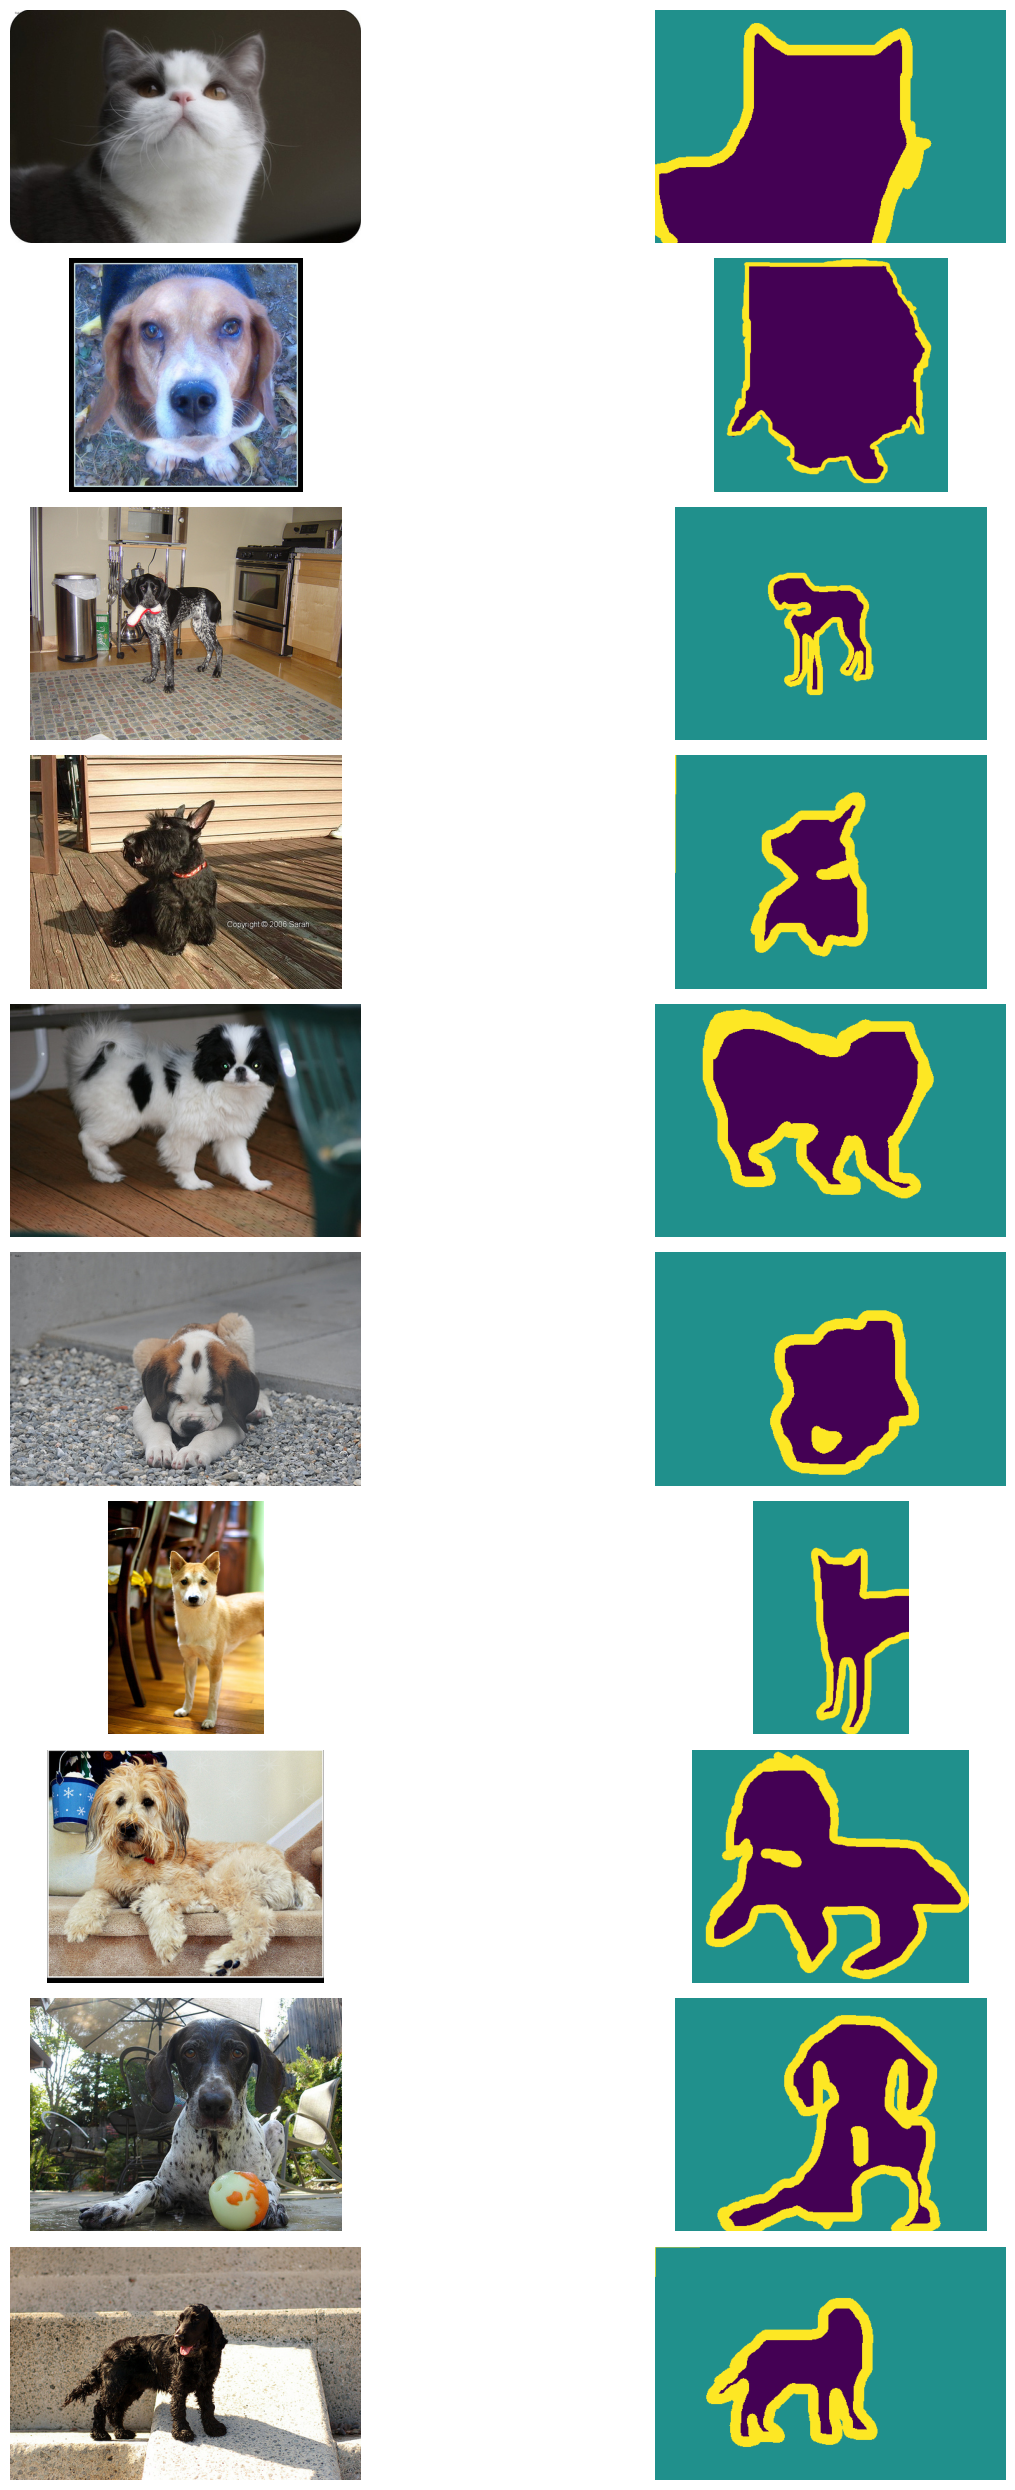

In [55]:
plot_examples(input_img_paths, target_img_paths, start=0, end=10)

## Prepare dataset to load & vectorize batches of data

In [12]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3) # transforms a png file into a tensor
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]

    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)


## Prepare U-Net Xception-style model

In [13]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 80, 80,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 80, 80,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 80, 80,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 80, 80,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 80, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 80, 80,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 40, 40,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 40, 40,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 40,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 40,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 40, 40,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 40, 40,    │          0 │ batch_normalizat

 Total params: 2,058,979 (7.85 MB)

 Trainable params: 2,055,203 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

## Set aside a validation split

In [14]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [23]:
print('Number of train batches: ', len(train_dataset))

Number of train batches:  32


In [24]:
print('Number of validation batches: ', len(valid_dataset))

Number of validation batches:  32


In [19]:
for data_batch in train_dataset:
  print("batch image shape:", data_batch[0].shape)
  print("batch mask shape:", data_batch[1].shape)
  break

batch image shape: (32, 160, 160, 3)
batch mask shape: (32, 160, 160, 1)


## Train the model

In [15]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/50
32/32 - 65s - 2s/step - loss: 1.5191 - val_loss: 1.1036
Epoch 2/50
32/32 - 8s - 255ms/step - loss: 0.8655 - val_loss: 1.4640
Epoch 3/50
32/32 - 11s - 344ms/step - loss: 0.7419 - val_loss: 2.0274
Epoch 4/50
32/32 - 6s - 197ms/step - loss: 0.6772 - val_loss: 2.6390
Epoch 5/50
32/32 - 6s - 201ms/step - loss: 0.6332 - val_loss: 3.2540
Epoch 6/50
32/32 - 6s - 188ms/step - loss: 0.5985 - val_loss: 3.8712
Epoch 7/50
32/32 - 10s - 321ms/step - loss: 0.5683 - val_loss: 4.4975
Epoch 8/50
32/32 - 9s - 281ms/step - loss: 0.5404 - val_loss: 5.1214
Epoch 9/50
32/32 - 6s - 196ms/step - loss: 0.5142 - val_loss: 5.7313
Epoch 10/50
32/32 - 10s - 320ms/step - loss: 0.4886 - val_loss: 6.2918
Epoch 11/50
32/32 - 10s - 312ms/step - loss: 0.4631 - val_loss: 6.7888
Epoch 12/50
32/32 - 7s - 215ms/step - loss: 0.4382 - val_loss: 7.1586
Epoch 13/50
32/32 - 6s - 189ms/step - loss: 0.4160 - val_loss: 7.2947
Epoch 14/50
32/32 - 7s - 213ms/step - loss: 0.3997 - val_loss: 7.1050
Epoch 15/50
32/32 - 10s - 3

## Visualize predictions

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step


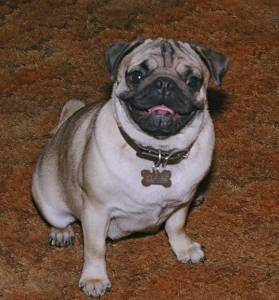

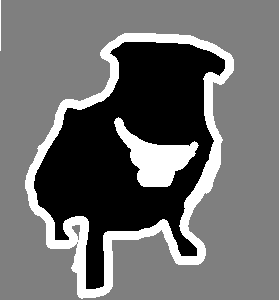

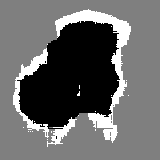

In [58]:
# Generate predictions for all images in the validation set

val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
img = Image.open(val_input_img_paths[i])
display(img)
#Image(val_input_img_paths[i])

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.